In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score

In [2]:
sentiment_dataset = pd.read_csv("Sentiment140_filtered.csv")

In [3]:
sentiment_dataset.head()

,Unnamed: 0,target,ids,date,flag,user,text,hate_pred
0,750,0,1467998601,Mon Apr 06 23:11:18 PDT 2009,NO_QUERY,Young_J,I'm off too bed. I gotta wake up hella early t...,1
1,766711,0,2300049112,Tue Jun 23 13:40:12 PDT 2009,NO_QUERY,dougnawoschik,I havent been able to listen to it yet My spe...,1
2,285055,0,1993474319,Mon Jun 01 10:26:09 PDT 2009,NO_QUERY,thireven,now remembers why solving a relatively big equ...,1
3,705995,0,2256551006,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,taracollins086,"Ate too much, feel sick",1
4,379611,0,2052381070,Sat Jun 06 00:32:23 PDT 2009,NO_QUERY,Portablemonkey,Tried to purchase a parked domain through GoDa...,1


In [4]:
sentiment_dataset.isnull().sum()

Unnamed: 0    0
target        0
ids           0
date          0
flag          0
user          0
text          0
hate_pred     0
dtype: int64

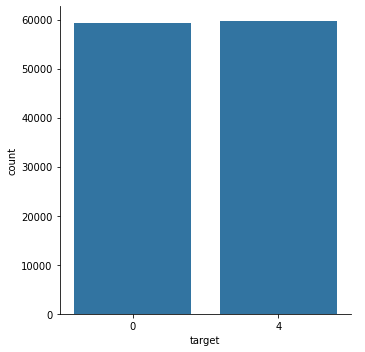

In [5]:
sns.catplot(x = 'target', data = sentiment_dataset, kind = 'count')


In [6]:
hateful_dataset = pd.read_csv("hateful_sentiment.csv")

In [7]:
hateful_dataset.head()

,Content,Label,Content_int
0,retweet to the rejects who constantly call my ...,1,"[146715, 1761, 7, 3, 22587, 67, 6768, 472, 129..."
1,i purpose that whatever attack everyone who ca...,1,"[146715, 80, 4226, 28, 220, 1347, 1568, 67, 65..."
2,are you fucking kidding me you deserve to fuck...,1,"[146715, 154, 26, 69, 1361, 78, 26, 6610, 7, 6..."
3,retweet i am not racist and i am not sexist i ...,1,"[146715, 1761, 80, 81, 76, 1723, 111, 80, 81, ..."
4,just imagine if the two million spent on the s...,1,"[146715, 14, 925, 204, 3, 672, 462, 5271, 9, 3..."


In [8]:
hateful_dataset = hateful_dataset[["Content", "Label"]]
hateful_dataset = hateful_dataset.rename(columns = {"Content": "text", "Label": "target"})
hateful_dataset["target"] = 2

hateful_dataset.head()

,text,target
0,retweet to the rejects who constantly call my ...,2
1,i purpose that whatever attack everyone who ca...,2
2,are you fucking kidding me you deserve to fuck...,2
3,retweet i am not racist and i am not sexist i ...,2
4,just imagine if the two million spent on the s...,2


In [9]:
sentiment_dataset = sentiment_dataset[["text", "target"]]
sentiment_dataset.head()

,text,target
0,I'm off too bed. I gotta wake up hella early t...,0
1,I havent been able to listen to it yet My spe...,0
2,now remembers why solving a relatively big equ...,0
3,"Ate too much, feel sick",0
4,Tried to purchase a parked domain through GoDa...,0


In [ ]:
sentiment_dataset.loc[sentiment_dataset['target']==4, 'target'] = 1
sentiment_dataset.loc[sentiment_dataset['target']==0, 'target'] = 0
# 0 - negative, 1 - positive, 2 - hateful

In [11]:
sentiment_dataset = pd.concat([sentiment_dataset, hateful_dataset], ignore_index= True)

In [12]:
sentiment_dataset.head()

,text,target
0,I'm off too bed. I gotta wake up hella early t...,0
1,I havent been able to listen to it yet My spe...,0
2,now remembers why solving a relatively big equ...,0
3,"Ate too much, feel sick",0
4,Tried to purchase a parked domain through GoDa...,0


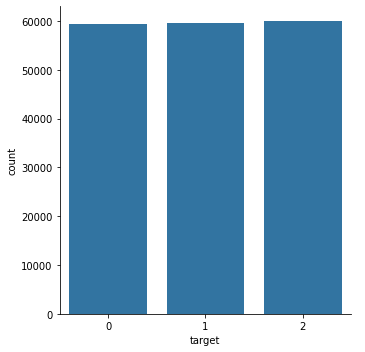

In [13]:
sns.catplot(x = 'target', data = sentiment_dataset, kind = 'count')

In [14]:
sentiment_dataset['target'].value_counts()

target
2    60000
1    59700
0    59300
Name: count, dtype: int64

In [15]:
sentiment_dataset.isnull().sum()

text      0
target    0
dtype: int64

In [16]:
X = sentiment_dataset['text']
y = sentiment_dataset['target']

CNN

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import re
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Tokenizacja i czyszczenie tekstu
def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text.split()

# Tworzenie słownika
all_tokens = [token for text in sentiment_dataset['text'] for token in tokenize(text)]
vocab = {word: i+2 for i, (word, _) in enumerate(Counter(all_tokens).most_common(10000))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

def encode(text):
    return [vocab.get(token, 1) for token in tokenize(text)]

In [19]:
# Dataset PyTorch
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [torch.tensor(encode(text)) for text in texts]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Padding collate function
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)
    return texts_padded, torch.tensor(labels)

In [20]:
# # Podział na zbiory
# X_train, X_val, y_train, y_val = train_test_split(sentiment_dataset['text'], sentiment_dataset['target'], test_size=0.2, stratify=sentiment_dataset['target'])

# train_dataset = TextDataset(X_train.tolist(), y_train.tolist())
# val_dataset = TextDataset(X_val.tolist(), y_val.tolist())

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [21]:
# Model CNN
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.conv1 = nn.Conv1d(embed_dim, 100, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(100, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # (batch, seq_len, embed_dim)
        x = x.permute(0, 2, 1)  # (batch, embed_dim, seq_len)
        x = self.relu(self.conv1(x))  # (batch, 100, seq_len-2)
        x = self.pool(x).squeeze(2)  # (batch, 100)
        return self.fc(x)

In [22]:
# Parametry
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TextCNN(vocab_size=len(vocab), embed_dim=100, num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Training fold 1/5...
Epoch 1/10 - Loss: 0.5209 - Accuracy: 0.7643
Epoch 2/10 - Loss: 0.3839 - Accuracy: 0.8316
Epoch 3/10 - Loss: 0.3292 - Accuracy: 0.8571
Epoch 4/10 - Loss: 0.2867 - Accuracy: 0.8782
Epoch 5/10 - Loss: 0.2466 - Accuracy: 0.8977
Epoch 6/10 - Loss: 0.2072 - Accuracy: 0.9171
Epoch 7/10 - Loss: 0.1697 - Accuracy: 0.9338
Epoch 8/10 - Loss: 0.1392 - Accuracy: 0.9471
Epoch 9/10 - Loss: 0.1104 - Accuracy: 0.9588
Epoch 10/10 - Loss: 0.0895 - Accuracy: 0.9666
Training fold 2/5...
Epoch 1/10 - Loss: 0.5196 - Accuracy: 0.7642
Epoch 2/10 - Loss: 0.3816 - Accuracy: 0.8332
Epoch 3/10 - Loss: 0.3283 - Accuracy: 0.8595
Epoch 4/10 - Loss: 0.2849 - Accuracy: 0.8797
Epoch 5/10 - Loss: 0.2447 - Accuracy: 0.8992
Epoch 6/10 - Loss: 0.2061 - Accuracy: 0.9174
Epoch 7/10 - Loss: 0.1691 - Accuracy: 0.9342
Epoch 8/10 - Loss: 0.1388 - Accuracy: 0.9473
Epoch 9/10 - Loss: 0.1119 - Accuracy: 0.9586
Epoch 10/10 - Loss: 0.0890 - Accuracy: 0.9672
Training fold 3/5...
Epoch 1/10 - Loss: 0.5187 - Accurac

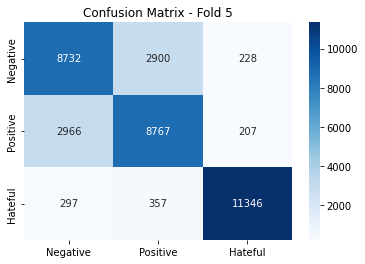

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np

# StratifiedKFold do podziału na 5 foldów
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lista do przechowywania wyników
results = []

# Funkcja ewaluacji modelu
def evaluate_model(model, val_loader):
    model.eval()  # Ustawienie modelu w tryb ewaluacji
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():  # Bez obliczania gradientów
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
    
    return true_labels, pred_labels

# Funkcja trenowania modelu z wyświetlaniem accur i loss po każdej epoce
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Obliczanie dokładności
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)
        
        # Obliczanie średniej straty i dokładności
        avg_loss = running_loss / len(train_loader)
        accuracy = correct_preds / total_preds
        
        # Wyświetlanie wyników dla bieżącej epoki
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f}")
    
    return model

# Trening i walidacja na 5 foldach
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold+1}/5...")
    
    # Przygotowanie danych
    train_texts, val_texts = X.iloc[train_idx], X.iloc[val_idx]
    train_labels, val_labels = y.iloc[train_idx], y.iloc[val_idx]
    
    # Przygotowanie DataLoaderów
    train_dataset = TextDataset(train_texts.tolist(), train_labels.tolist())
    val_dataset = TextDataset(val_texts.tolist(), val_labels.tolist())
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
    
    # Inicjalizacja modelu
    model = TextCNN(vocab_size=len(vocab), embed_dim=100, num_classes=3).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    # Trenowanie modelu z wyświetlaniem accur i loss
    model = train_model(model, train_loader, criterion, optimizer, epochs=10)
    
    # Ewaluacja modelu
    true_labels, pred_labels = evaluate_model(model, val_loader)
    
    # Obliczenie metryk
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    cm = confusion_matrix(true_labels, pred_labels)
    
    # Zapisanie wyników
    results.append({
        "fold": fold + 1,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm
    })
    
    # Zapisanie najlepszego modelu (jeśli jest lepszy od poprzedniego)
    if fold == 0 or f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"best_model_fold_32_{fold+1}.pth")

# Podsumowanie wyników
results_df = pd.DataFrame(results)
print(results_df)

# Opcjonalnie: Wyświetlenie confusion matrix dla ostatniego modelu
sns.heatmap(results_df["confusion_matrix"].iloc[-1], annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive", "Hateful"], yticklabels=["Negative", "Positive", "Hateful"])
plt.title(f"Confusion Matrix - Fold {5}")
plt.show()
